$\color{cyan}{\textbf{Assignment 3 - Eigen Faces}}$

Trabalho realizado por:

    Pedro Ferreira Nº2018285801
    Telmo Cunha Nº 2018308321

$\color{cyan}{\textbf{Imports}}$

In [1]:
from time import time
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import math
import numpy.matlib
from random import randint

In [2]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[int(y_pred[i])]
    true_name = target_names[int(y_test[i])]
    return "predicted: %s\ntrue:      %s" % (pred_name, true_name)

$\color{cyan}{\textbf{Build the dataset}}$

In [3]:
flag = "age"
balance_dataset = False

In [4]:
separation = 10

folderPath = "Image Datasets/crop_part1"
files_paths = os.listdir(folderPath)

img = cv2.imread(os.path.join(folderPath ,files_paths[0]))
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
h, w = img_gray.shape
        
img_data = []
labels_origin = []

for filename in files_paths:
    img = cv2.imread(os.path.join(folderPath ,filename))

    x = filename.split("_")

    if flag.lower()=="age":
        labels_origin.append(math.floor((int(x[0])+1)/separation))
    else:
        index=1
        if len(x)<4:
            continue

        labels_origin.append(int(x[1]))
        
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
    img_data.append(img_gray.ravel())

img_data = np.array(img_data)
labels_origin = np.array(labels_origin)
print("Total labels: "+str(len(labels_origin)))
print("Total images: "+str(len(img_data)))

Total labels: 9780
Total images: 9780


In [5]:
#Verify if there's a class with few examples, and eliminates it

labels = labels_origin
classes = np.unique(labels)
print("Classes:", classes)
for i in range(len(classes)):
    Classe_N = sum((labels==classes[i]).astype('int'))
    
    print("Class", i , "has" ,Classe_N, "samples.")
    if Classe_N<100:
        indexs = np.array(np.where(labels==classes[i])).ravel()
        labels = np.delete(labels, indexs)
        img_data = np.delete(img_data, indexs, 0)

classes = np.unique(labels)
print(classes)

Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Class 0 has 2787 samples.
Class 1 has 1319 samples.
Class 2 has 1425 samples.
Class 3 has 1048 samples.
Class 4 has 712 samples.
Class 5 has 978 samples.
Class 6 has 670 samples.
Class 7 has 408 samples.
Class 8 has 318 samples.
Class 9 has 108 samples.
Class 10 has 5 samples.
Class 11 has 2 samples.
[0 1 2 3 4 5 6 7 8 9]


In [6]:
#if we need to balance the dataset (same number of examples in each class)

if balance_dataset == True:
    threshold=100
    counter=np.zeros((1,len(classes)))

    labels_copy = []
    img_data_copy = []

    for i in range(len(classes)):
        classe = classes[i]
        for j in range(len(labels)):
            if classe==labels[j]:
                counter[0,i] = counter[0,i] + 1
                labels_copy.append(labels[j])
                img_data_copy.append(img_data[j,:])
            if counter[0,i]>=threshold:
                break

        print(i,"-",counter)

    labels = np.array(labels_copy)
    img_data = np.array(img_data_copy)

print("Total labels: "+str(len(labels)))
print("Total images: "+str(len(img_data)))

Total labels: 9773
Total images: 9773


$\color{cyan}{\textbf{Verifying the data}}$

In [7]:
# introspect the images arrays to find the shapes (for plotting)
n_samples = len(labels) 

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = img_data
n_features = h*w

# the label to predict is the id of the person
y = labels
n_classes =len(np.unique(y))

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 9773
n_features: 40000
n_classes: 10


$\color{cyan}{\textbf{Split the Dataset}}$

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

$\color{cyan}{\textbf{Preprocess the datasets}}$

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

mu = np.mean(X_train, axis=0)
mu1 = np.matlib.repmat(np.mean(X_train, axis=0), len(X_train), 1)
mu2 = np.matlib.repmat(np.mean(X_test, axis=0), len(X_test), 1)
X_train = X_train-mu1
X_test = X_test-mu2

In [10]:
#Get class names for plotting
target_names = []
c_class = np.unique(y_test)
genders = ["Male","Female"]

if flag.lower()=="age":
    dist = 10
    for i in range(len(np.unique(y_test))):
        target_names.append(str(dist*c_class[i])+"-"+str(dist*c_class[i]+dist-1))
else:

    for i in range(len(np.unique(y_test))):
        target_names.append(genders[i])


$\color{cyan}{\textbf{PCA Calculation and projection}}$

In [11]:
n_components = 200

print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))

t0 = time()
pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 200 eigenfaces from 7329 faces
done in 16.774s
Projecting the input data on the eigenfaces orthonormal basis
done in 1.865s


$\color{cyan}{\textbf{Fitting the data}}$

In [12]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {"C": loguniform(1e3, 1e5),"gamma": loguniform(1e-4, 1e-1),}

#clf = RandomizedSearchCV(SVC(kernel="linear", class_weight="balanced"), param_grid, n_iter=10)

clf = SVC(kernel="linear", class_weight="balanced", C=10)

clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
#print(clf.best_estimator_)

Fitting the classifier to the training set
done in 480.012s
Best estimator found by grid search:


$\color{cyan}{\textbf{Getting performance measurements on the training data}}$

Predicting people's names on the training set
done in 2.088s
              precision    recall  f1-score   support

         0-9       0.95      0.88      0.91      2087
       10-19       0.61      0.73      0.67       980
       20-29       0.65      0.62      0.64      1077
       30-39       0.53      0.54      0.53       776
       40-49       0.51      0.57      0.53       532
       50-59       0.60      0.48      0.53       753
       60-69       0.55      0.54      0.55       495
       70-79       0.68      0.73      0.70       306
       80-89       0.75      0.91      0.82       245
       90-99       0.99      1.00      0.99        78

    accuracy                           0.70      7329
   macro avg       0.68      0.70      0.69      7329
weighted avg       0.70      0.70      0.70      7329

Mean Precision: 0.680841092943832
Mean F1-Score: 0.6881194978039076
Mean Recall: 0.6999336849846411


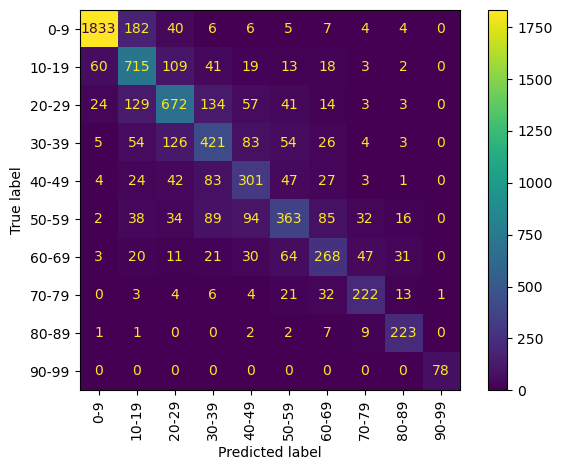

In [13]:
print("Predicting people's names on the training set")
t0 = time()
y_pred = clf.predict(X_train_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_train, y_pred, target_names=target_names))
print("Mean Precision: "+str(precision_score(y_train, y_pred, average='macro')))
print("Mean F1-Score: "+str(f1_score(y_train, y_pred, average='macro')))
print("Mean Recall: "+str(recall_score(y_train, y_pred, average='macro')))


ConfusionMatrixDisplay.from_estimator(
    clf, X_train_pca, y_train, display_labels=target_names, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

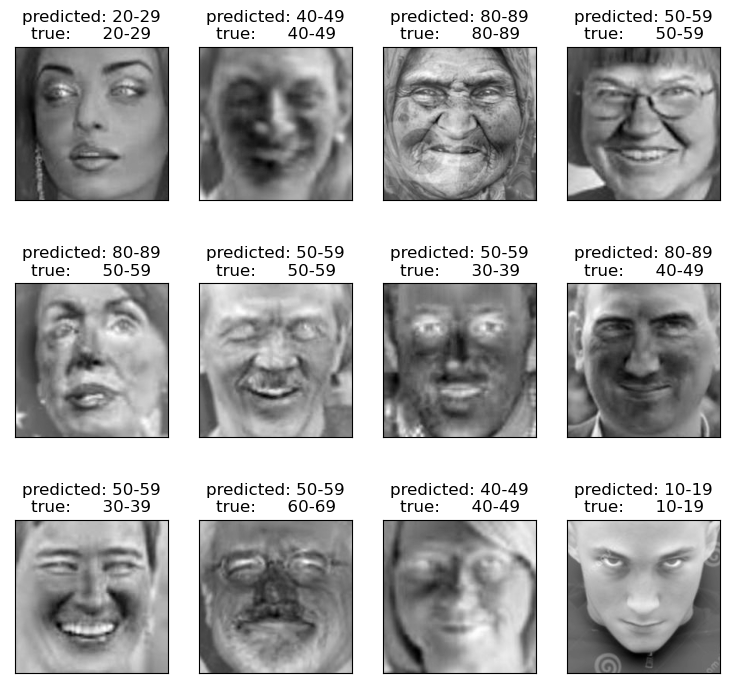

In [14]:
prediction_titles = [title(y_pred, y_train, target_names, i) for i in range(y_pred.shape[0])]
plot_gallery(X_train, prediction_titles, h, w)

$\color{cyan}{\textbf{Getting performance measurements on the test data}}$

Predicting people's names on the test set
done in 0.700s
              precision    recall  f1-score   support

         0-9       0.87      0.81      0.84       700
       10-19       0.45      0.53      0.49       339
       20-29       0.52      0.49      0.50       348
       30-39       0.33      0.36      0.35       272
       40-49       0.25      0.28      0.26       180
       50-59       0.30      0.28      0.29       225
       60-69       0.24      0.21      0.23       175
       70-79       0.32      0.31      0.32       102
       80-89       0.25      0.29      0.27        73
       90-99       0.32      0.27      0.29        30

    accuracy                           0.50      2444
   macro avg       0.39      0.38      0.38      2444
weighted avg       0.51      0.50      0.50      2444

Mean Precision: 0.38531180867785003
Mean F1-Score: 0.38271729729965565
Mean Recall: 0.3824169491828345


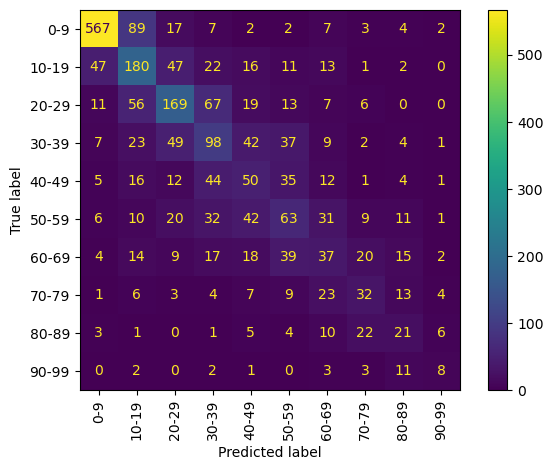

In [15]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print("Mean Precision: "+str(precision_score(y_test, y_pred, average='macro')))
print("Mean F1-Score: "+str(f1_score(y_test, y_pred, average='macro')))
print("Mean Recall: "+str(recall_score(y_test, y_pred, average='macro')))
ConfusionMatrixDisplay.from_estimator(
    clf, X_test_pca, y_test, display_labels=target_names, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

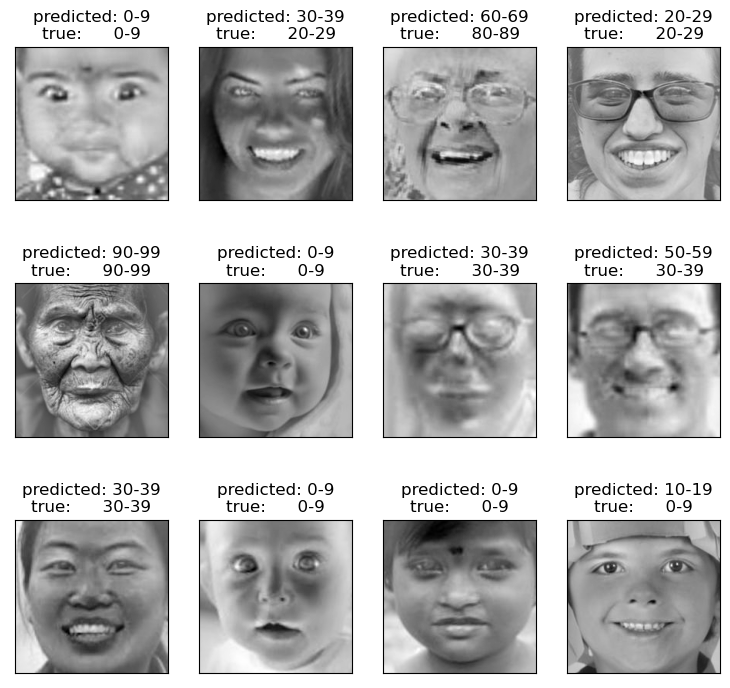

In [16]:
prediction_titles = [title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

$\color{cyan}{\textbf{Visualize the Eigen Faces}}$

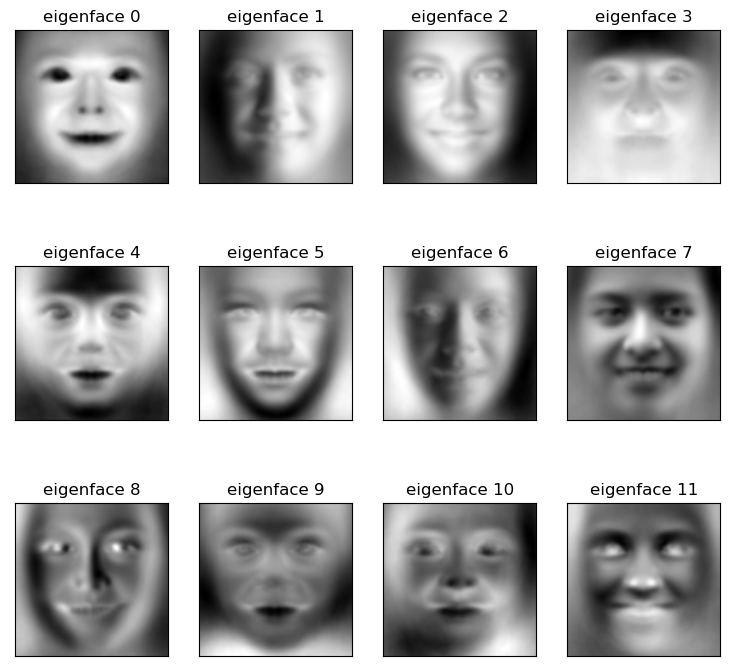

In [17]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

$\color{cyan}{\textbf{Trying to reconstruct the original data}}$

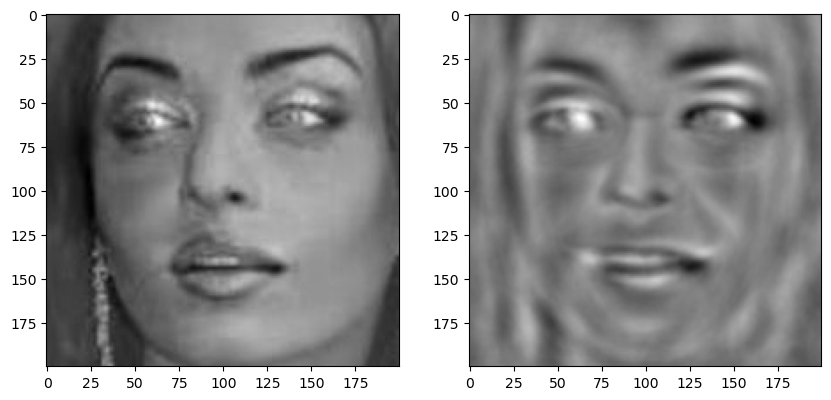

In [18]:
index = 0

img_O = np.reshape(X_train[index,:], (200,200)) 
img = np.matmul(np.reshape(X_train_pca[index,:], (1,len(X_train_pca[index,:]))),  pca.components_ ) + mu
img = np.reshape(img, (200,200)) 

fig = plt.figure(figsize=(10, 7))
rows = 1
columns = 2

fig.add_subplot(rows, columns, 1)
plt.imshow(img_O, cmap='gray')
fig.add_subplot(rows, columns, 2)
plt.imshow(img, cmap='gray')

plt.show()

$\color{cyan}{\textbf{Ploting relation between first and second components}}$

In [19]:
x_aux = X_train_pca[0:100, :]
y_aux = y_train[0:100]

In [20]:

X_aux = []
counter = np.zeros(len(c_class))

for i in range(len(c_class)):
    for j in range(len(y_train)):
        if y_train[j]==c_class[i]:
            X_aux.append(X_train_pca[j])
            counter[i] = counter[i] + 1
    
X_aux = np.array(X_aux)

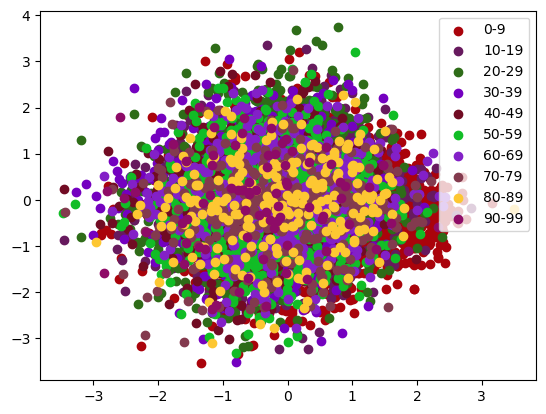

In [21]:
cols = ['#{:06x}'.format(randint(0, 0xffffff)) for i in range(len(y_aux))]
pltCol = [cols[int(k)] for k in range(len(c_class))]

plt.figure()

for i in range(len(c_class)):

    sup_index = int(np.sum(counter[:i+1])-1)
    inf_index = int(np.sum(counter[:i])-1)

    if sup_index<0: sup_index=0
    if inf_index<0: inf_index=0

    plt.scatter(X_aux[inf_index:sup_index, 0], X_aux[inf_index:sup_index, 1], color=pltCol[i], label = target_names[i])


plt.legend()
plt.show()